# Tense prediction

In [1]:
import codecs
import re
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from estnltk import Text

In [3]:
print( Text('Tere estnltk').lemmas )

['tere', 'estnltk']


In [4]:
DATA_DIR = "../data/"

### Read corpora

In [5]:
with codecs.open(DATA_DIR+"cleaned-tc-tok-train.en", "r", "utf8") as f:
    en = [line.strip() for line in f]
with codecs.open(DATA_DIR+"cleaned-tc-tok-train.et", "r", "utf8") as f:
    et = [line.strip() for line in f]

In [7]:
print(len(en), len(et))

16000667 16000667


### Grep for future tense markers

In [8]:
pattern = re.compile("(.*)((will)|(&apos;ll)|(won &apos;t)|((am|is|are|&apos;re|&apos;s|&apos;m)( not)? (going to|gonna)))")

Find all matched strings:

In [9]:
labels = np.asarray([1 if re.match(pattern, string) else 0 for string in en])

In [10]:
np.sum(labels)

766440

In [13]:
with open("train_future_labels.en", "w") as f:
    f.writelines([str(l) for l in labels])

In [8]:
with open("train_future_labels.en", "r") as f:
    labels = np.array([int(i) for i in f.read()])

Select equal number of future tense strings and other:

In [9]:
CLASS_SIZE = min(400000, np.sum(labels))
CLASS_SIZE

400000

In [10]:
np.random.seed(42)
ind_fut = np.random.choice(np.where(labels == 1)[0], CLASS_SIZE)
ind_oth = np.random.choice(np.where(labels == 0)[0], CLASS_SIZE)
print(len(ind_fut), len(ind_oth))

400000 400000


Check matched sentences:

In [15]:
matched = np.array([en[i] for i in ind_fut])
matched[:20]

array([ 'we &apos;ll pay the usual premium for tradesmen and fertile women , et cetera .',
       'ECB staff will then make the photocopies .',
       'it &apos;s gonna happen .',
       'we &apos;re not quite in Vegas yet , but we &apos;ll get there eventually .',
       'I &apos;m gonna pin it on him .', 'I &apos;m going to bed .',
       'as regards third-party documents , the CIS will consult the third party concerned before proceeding to carry out the declassification .',
       'right , then maybe we &apos;ll make some of our money back for filming this .',
       'we &apos;re trying to work out a schedule of the outfits we &apos;re gonna play this year .',
       'this will help the EU get back onto the path of economic growth by fostering scientific excellence and research , underpinning innovation and increasing the attractiveness of the EU as a research location .',
       'if , in an off-premises contract , the goods , by their nature , cannot normally be returned by post an

### Create train and test sets

In [16]:
X = np.concatenate([np.array([et[i] for i in ind_fut]), np.array([et[i] for i in ind_oth])])

800000 800000


In [11]:
y = np.concatenate([labels[ind_fut], labels[ind_oth]])

In [ ]:
print(len(X), len(y))

Lemmatize everything except verbs:

In [17]:
def lemmatize(sent):
    text = Text(sent)
    return ' '.join([text.lemmas[i].split('|')[0]  # Take lemma
                     if pt.split('|')[0] != 'V'    # if word is not a verb
                     else text.word_texts[i]       # else take the verb itself
                     for i, pt in enumerate(text.postags)])

In [18]:
lemmatize(X[0])

'maksame tavapärane tasu kaupmees ja viljakas naine eest ...'

In [19]:
lemX = np.array([lemmatize(s) for s in X])

In [3]:
len(lemX)

800000

In [21]:
with open("lemmatized_800k.et", "w") as f:
    f.write("\n".join(lemX))

In [2]:
with open("lemmatized_800k.et", "r") as f:
    lemX = np.array([s.strip() for s in f])

______

## Train the network

In [25]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
import pickle

In [5]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 30000
EMBEDDING_DIM = 100

Tokenizer:

In [13]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(lemX)
sequences = tokenizer.texts_to_sequences(lemX)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 193610 unique tokens.


In [26]:
# saving
with open('tokenizer_400k.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# loading
with open('tokenizer_400k.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [14]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = to_categorical(y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (800000, 1000)
Shape of label tensor: (800000, 2)


Split the data:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=10)

In [16]:
K.clear_session()

In [17]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [18]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(units=EMBEDDING_DIM, recurrent_dropout=0.2, dropout=0.4))(embedded_sequences)
preds = Dense(2, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# checkpoint
filepath="lstm_fut_binary_model_400k_adam_dropout02-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         19361100  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 19,522,302
Trainable params: 19,522,302
Non-trainable params: 0
_________________________________________________________________


In [19]:
model = load_model("lstm_fut_binary_model_400k_adam_dropout02-00-0.82.hdf5")

In [20]:
history = model.fit(
    X_train, 
    y_train, 
    validation_split=0.2, 
    callbacks=callbacks_list,
    shuffle=True,
    epochs=4, 
    batch_size=256)

Train on 512000 samples, validate on 128000 samples
Epoch 1/4
512000/512000 [==============================] - 7164s - loss: 0.3894 - acc: 0.8273 - val_loss: 0.3952 - val_acc: 0.8244
Epoch 2/4
512000/512000 [==============================] - 6897s - loss: 0.3589 - acc: 0.8429 - val_loss: 0.3941 - val_acc: 0.8273
Epoch 3/4
512000/512000 [==============================] - 6873s - loss: 0.3424 - acc: 0.8510 - val_loss: 0.3964 - val_acc: 0.8282
Epoch 4/4
512000/512000 [==============================] - 6889s - loss: 0.3247 - acc: 0.8599 - val_loss: 0.4000 - val_acc: 0.8287


In [33]:
model

In [105]:
model.save_weights('lstm_fut_binary_model_48k_adam_dropout02.h5')

with open('lstm_fut_model_48k_adam_dropout02_def.json','w') as ff:
    json_string = model.to_json()
    ff.write(json_string)

In [21]:
import matplotlib.pyplot as plt

In [22]:
def plot_learning_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.clf()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

plot_learning_curve(history)

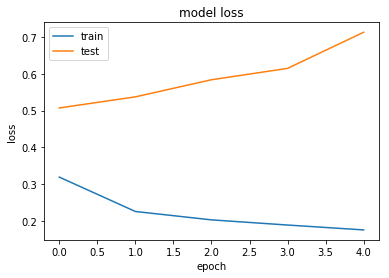

In [114]:
plt.show()

### Accuracy

In [23]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

Predicting on test data
0.82735


### Confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test[:,0], y_pred[:,0]))

[[67290 12513]
 [15111 65086]]


### Misclassified

In [28]:
false_positive = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 0))
false_negative = np.intersect1d(np.where(y_pred == 0), np.where(y_test == 1))

In [29]:
fp = en[false_positive]
fp[:20]

array(['Krahmer report A6-0046 / 2009 — Amendment 5 / 2', 'go !',
       '~ Gosh ! they smell so good . ~ Yeah !',
       'the Court considers , however , that grants should be awarded on the basis of Commission decisions since , according to the Financial Regulation , the use of the Commission decision procedure is a pre-condition for agreeing on negotiated flat rates for indirect costs , established according to the usual cost accounting practices of the participant , over and above the 7 % established by the Financial Regulation ( see paragraphs 69 and 70 ) .',
       '15 .',
       '( 11a ) In accordance with the objectives of the Community Action Plan on the Protection and Welfare of Animals ( 2006 – 2010 ) the Commission should endeavour to promote the welfare of animals used for scientific purposes internationally , and in particular to seek promotion of the replacement , reduction and refinement of animal procedures through the World Organisation for Animal Health ( OIE ) , and

------

## Estonian sentences

Split by clauses

In [14]:
class PresText(Text):

    def __init__(self, sentence):
        Text.__init__(self, sentence)
        self.present_indices = self.present_ind()
        self.clauses_with_present = self.clauses_present()

    def present_ind(self):
        present_tags = ['b', 'd', 'ge', 'gem', 'gu', 'ks', 'ksid', 'ksime', 'ksin', 'ksite', 'me', 'n', 'neg ge',
                        'neg gem', 'neg gu', 'neg ks', 'meg me', 'neg o', 'neg vat', 'o', 'ta', 'tagu', 'taks',
                        'takse', 'tav', 'tavat', 'te', 'v', 'vad', 'vat']
        return [i for i, t in enumerate(self.get.forms.as_list[0]) if t in present_tags]

    def clauses_present(self):
        clauses_present = [self.clause_texts[j] for j in [self.clause_indices[i] for i in self.present_indices]]
        return clauses_present